**BÀI TOÁN DỰ ĐOÁN NHU CẦU ĐI XE TAXI MÀU VÀNG CỦA KHÁCH THEO TỪNG KHU VỰC TRONG THÀNH PHỐ NEW YORK**

#DATASET AND IMPORT LIBRARIES

Tên data: 2020 Yellow Taxi Trip Data (January - June)

Kích thước: 16.8M row, 18 Columns

Nguồn: https://data.cityofnewyork.us/Transportation/2020-Yellow-Taxi-Trip-Data-January-June-/kxp8-n2sj


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install "dask[complete]"
!pip install pyshp

     |████████████████████████████████| 675kB 10.7MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=4021eaa9f44e1b9fac035eea423f221dcdbd84064d507bfcdb687bbe55b0b5c7
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=210a758a21d4beb61ea82319f37fab0b73e7773c1e8af4ad8783b4dfd784cfd8
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built locket contextvars
ERROR: distributed 2020.12.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2020.12.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distri

In [5]:
#!pip install --upgrade pip
#!pip install --upgrade pandas
!pip install --upgrade scipy
!pip install --upgrade tensorflow
#!pip install tensorflow-gpu==1.15
!pip install --upgrade keras==2.3.0

     |████████████████████████████████| 25.9MB 121kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
     |████████████████████████████████| 378kB 8.6MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [6]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt # Graph plot
from scipy import stats
from datetime import datetime
import re
import random
from math import sqrt
import seaborn as sns

# Using dask dataframe for data which have a big size as 16.8M lines
import pickle
import dask.dataframe as dd
# For faster processing
import dask.multiprocessing

#DEFINE THE PROBLEM - SOLVE

Bộ dữ liệu này ghi lại dữ liệu của các chuyến đi của xe taxi màu Vàng ở New York Mỹ của năm 2020 từ tháng 1 đến tháng 6.

Bài toán của chúng ta ở đây là dự đoán nhu cầu của khách hàng đối với những chiếc taxi màu vàng theo vị trí, để làm được điều này ta phải thăm dò (EDA) sâu từng features có liên quan đến bài toán. Vấn đề ở đây là bộ dữ liệu của chúng ta với số hàng tương đương với số chuyến đi rất rất lớn, một khi đi vào EDA sâu từng features sẽ rất mất thời gian RUN. Vì vậy, em đã dùng một thư viện có sẵn với cấu trúc giống như database có thể truy vấn là dask sẽ làm giảm thời gian thực thi của chúng ta.

Sử dụng modules dataframe trong thư viện Dask với việc chia dữ liệu của chúng ta thành nhiều phân vùng dữ liệu ( partitions ), cụ thể bộ này được chia làm 26 vùng. Link nguồn thuật toán có thể tham khảm ở đây:
https://docs.dask.org/en/latest/dataframe.html

In [7]:
#Format data của thư viện dask
new_data_types = \
{
'VendorID': 'float64',
'tpep_pickup_datetime' :      'object',
'tpep_dropoff_datetime' :     'object',
'passenger_count' :          'float64',
'trip_distance' :           'float64',
'RatecodeID' :               'float64',
'store_and_fwd_flag' :        'object',
'PULocationID' :             'float64',
'DOLocationID' :             'float64',
'payment_type' :             'float64',
'fare_amount' :              'float64',
'extra' :                    'float64',
'mta_tax' :                  'float64',
'tip_amount' :               'float64',
'tolls_amount' :             'float64',
'improvement_surcharge' :    'float64',
'total_amount' :             'float64',
'congestion_surcharge' :     'float64'
}

In [ ]:
#Read data use pandas
#dataset = pd.read_csv('/content/drive/MyDrive/2020_Yellow_Taxi_Trip_Data__January_-_June_.csv')

In [8]:
#Read data by using libraries Dask
data = dd.read_csv('/content/drive/MyDrive/data_yellow/2020_Yellow_Taxi_Trip_Data__January_-_June_.csv', dtype = new_data_types)

In [7]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=26,,,,,,,,,,,,,,,,,,
,float64,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
data.npartitions

26

In [9]:
data.partitions[0].compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.20,1.0,N,238.0,239.0,1.0,6.0,3.0,0.5,1.47,0.00,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.20,1.0,N,239.0,238.0,1.0,7.0,3.0,0.5,1.50,0.00,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.60,1.0,N,238.0,238.0,1.0,6.0,3.0,0.5,1.00,0.00,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.80,1.0,N,238.0,151.0,1.0,5.5,0.5,0.5,1.36,0.00,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.00,1.0,N,193.0,193.0,2.0,3.5,0.5,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658588,1.0,01/04/2020 09:47:29 PM,01/04/2020 09:59:43 PM,2.0,1.40,1.0,N,249.0,211.0,1.0,9.0,3.0,0.5,1.54,0.00,0.3,14.34,2.5
658589,1.0,01/04/2020 09:25:29 PM,01/04/2020 09:38:31 PM,1.0,6.20,1.0,N,140.0,244.0,2.0,18.5,3.0,0.5,0.00,0.00,0.3,22.30,2.5
658590,2.0,01/04/2020 09:59:42 PM,01/04/2020 10:28:57 PM,1.0,10.54,1.0,N,138.0,50.0,1.0,32.5,0.5,0.5,12.73,6.12,0.3,55.15,2.5
658591,2.0,01/04/2020 09:07:44 PM,01/04/2020 09:16:15 PM,1.0,1.01,1.0,N,107.0,164.0,1.0,7.0,0.5,0.5,1.62,0.00,0.3,12.42,2.5


In [12]:
data.partitions[25].compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,06/11/2020 07:39:38 AM,06/11/2020 07:51:31 AM,1.0,1.68,1.0,N,74.0,263.0,1.0,9.50,0.0,0.5,1.08,0.00,0.3,13.88,2.5
1,2.0,06/11/2020 07:20:33 AM,06/11/2020 07:30:38 AM,1.0,2.38,1.0,N,239.0,246.0,1.0,10.00,0.0,0.5,1.50,0.00,0.3,14.80,2.5
2,1.0,06/11/2020 07:10:16 AM,06/11/2020 07:12:59 AM,1.0,0.40,1.0,N,224.0,107.0,1.0,4.00,2.5,0.5,1.10,0.00,0.3,8.40,2.5
3,1.0,06/11/2020 07:17:10 AM,06/11/2020 07:30:03 AM,1.0,2.20,1.0,N,224.0,100.0,1.0,10.50,2.5,0.5,0.00,0.00,0.3,13.80,2.5
4,1.0,06/11/2020 07:59:34 AM,06/11/2020 08:11:12 AM,1.0,2.80,1.0,N,224.0,140.0,2.0,11.00,2.5,0.5,0.00,0.00,0.3,14.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413581,NaN,06/30/2020 11:05:00 PM,06/30/2020 11:32:00 PM,NaN,12.96,NaN,NaN,17.0,69.0,NaN,32.91,0.0,0.5,2.75,6.12,0.3,42.58,0.0
413582,NaN,06/30/2020 11:21:47 PM,06/30/2020 11:25:24 PM,NaN,0.36,NaN,NaN,41.0,41.0,NaN,11.45,0.0,0.5,2.75,0.00,0.3,15.00,0.0
413583,NaN,06/30/2020 11:34:00 PM,06/30/2020 11:44:00 PM,NaN,2.36,NaN,NaN,242.0,81.0,NaN,18.45,0.0,0.5,2.75,0.00,0.3,22.00,0.0
413584,NaN,06/30/2020 11:22:47 PM,06/30/2020 11:42:01 PM,NaN,5.50,NaN,NaN,14.0,118.0,NaN,15.90,0.0,0.5,6.23,12.24,0.3,35.17,0.0


In [13]:
len(data)

16847778

In [14]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [15]:
data.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID             float64
DOLocationID             float64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [8]:
final_data_types = \
{
'VendorID': 'float64',
'tpep_pickup_datetime' :      'datetime64[ns]',
'tpep_dropoff_datetime' :     'datetime64[ns]',
'passenger_count' :          'float64',
'trip_distance' :           'float64',
'RatecodeID' :               'float64',
'store_and_fwd_flag' :        'object',
'PULocationID' :             'float64',
'DOLocationID' :             'float64',
'payment_type' :             'float64',
'fare_amount' :              'float64',
'extra' :                    'float64',
'mta_tax' :                  'float64',
'tip_amount' :               'float64',
'tolls_amount' :             'float64',
'improvement_surcharge' :    'float64',
'total_amount' :             'float64',
'congestion_surcharge' :     'float64'
}

#EXPLORATORY DATA ANALYSIS

##Thăm dò dữ liệu của 2 cột thời gian giữa các partition

In [9]:
# convert string to numpy datetype
def convert_dates(df):
    df = df.assign(tpep_pickup_datetime=pd.to_datetime(df['tpep_pickup_datetime'], format="%m/%d/%Y %I:%M:%S %p"))
    df = df.assign(tpep_dropoff_datetime=pd.to_datetime(df['tpep_dropoff_datetime'], format="%m/%d/%Y %I:%M:%S %p"))
    return df

In [10]:
# map_partition applies a function to each partition
data = data.map_partitions(convert_dates, meta=final_data_types)

In [19]:
data.tail(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
413581,NaN,2020-06-30 23:05:00,2020-06-30 23:32:00,NaN,12.96,NaN,NaN,17.0,69.0,NaN,32.91,0.0,0.5,2.75,6.12,0.3,42.58,0.0
413582,NaN,2020-06-30 23:21:47,2020-06-30 23:25:24,NaN,0.36,NaN,NaN,41.0,41.0,NaN,11.45,0.0,0.5,2.75,0.00,0.3,15.00,0.0
413583,NaN,2020-06-30 23:34:00,2020-06-30 23:44:00,NaN,2.36,NaN,NaN,242.0,81.0,NaN,18.45,0.0,0.5,2.75,0.00,0.3,22.00,0.0
413584,NaN,2020-06-30 23:22:47,2020-06-30 23:42:01,NaN,5.50,NaN,NaN,14.0,118.0,NaN,15.90,0.0,0.5,6.23,12.24,0.3,35.17,0.0
413585,NaN,2020-06-30 23:56:18,2020-07-01 00:27:19,NaN,9.59,NaN,NaN,61.0,137.0,NaN,29.68,0.0,0.5,0.00,0.00,0.3,32.98,2.5


In [252]:
data[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].max().compute()

tpep_pickup_datetime    2021-01-02 01:12:10
tpep_dropoff_datetime   2021-01-02 01:25:01
dtype: datetime64[ns]

In [253]:
data[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].min().compute()

tpep_pickup_datetime    2003-01-01 00:07:17
tpep_dropoff_datetime   2003-01-01 14:16:59
dtype: datetime64[ns]

In [254]:
# Giá trị ngoại lệ trong 2 cột thời gian
outlier_dates = data.query("(tpep_pickup_datetime.dt.year != 2020) | (tpep_dropoff_datetime.dt.year != 2020)").compute()
len(outlier_dates)

221

In [11]:
# remove outlier
# Sử dụng còn outlier vẫn còn trong tham số data
new_data = data.query("tpep_pickup_datetime.dt.year == 2020")

##Visulize tất cả mã khu vực trên bản đồ thành phố New York ( Geographical ploting)


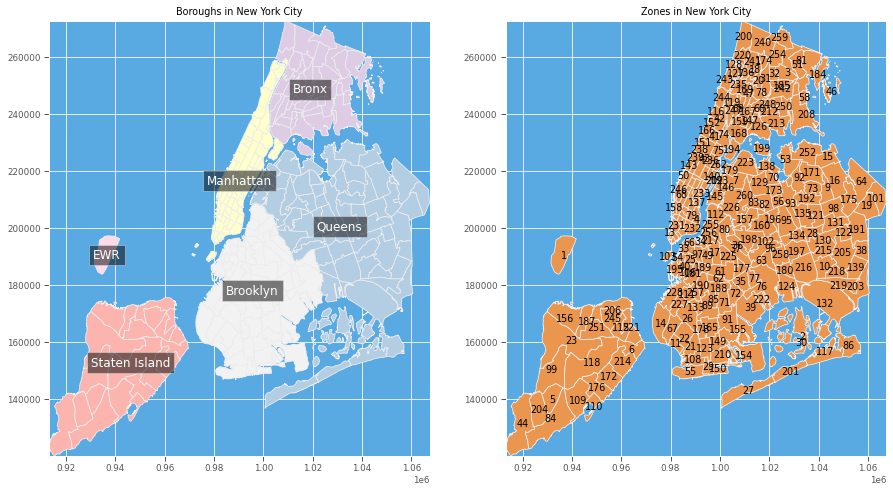

Link sourses code hình được visualize trên: https://colab.research.google.com/drive/193sLGD6bySUDagx-IY9X4G0ePAItJcZ7?usp=sharing

## Thăm dò dữ liệu của 6 quận trong bộ dữ liệu


Việc thăm dò bằng cách gán nhãn tên các quận trong thành phố để dễ dàng thăm do bằng cách sử dụng một bộ data có sẵn trong cùng một nguồn với dữ liệu chính:

Link data: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [12]:
# load zone lookup csv
zone_lookup = pd.read_csv("/content/taxi+_zone_lookup.csv")
zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(zone_lookup.Borough)
print(le.classes_)
zone_lookup.loc[:, "Label"] = le.transform(zone_lookup.Borough)
zone_lookup[["Borough", "Label"]].head()

['Bronx' 'Brooklyn' 'EWR' 'Manhattan' 'Queens' 'Staten Island' 'Unknown']


,Borough,Label
0,EWR,2
1,Queens,4
2,Bronx,0
3,Manhattan,3
4,Staten Island,5


In [14]:
# convert it to dictionary for easy access
zone_dict = dict(zip(zone_lookup.LocationID, zone_lookup.Label))

In [16]:
# create new column
new_data["borugh_label"] =new_data.PULocationID.map(zone_dict)
new_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,borugh_label
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238.0,239.0,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,3
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239.0,238.0,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,3
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238.0,238.0,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,3
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238.0,151.0,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,3
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193.0,193.0,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,4


In [30]:
# Số lượng chuyến xe của 6 quận
trips_by_borough_2020 = new_data.borugh_label.groupby(new_data.borugh_label).count()
trips_by_borough_2020 = trips_by_borough_2020.compute().sort_values(ascending=False)
trips_by_borough_2020

borugh_label
3    15386529
4     1050082
1      223384
6      122042
0       61950
5        1809
2        1762
Name: borugh_label, dtype: int64

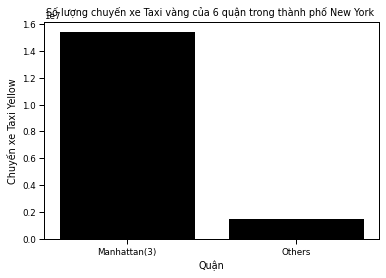

In [274]:
#Vẽ biểu đồ cột thể hiện số lượng trên
raw_trip = ['Manhattan(3)','Others']
trip_share = [15386529,1461249]
plt.bar(raw_trip, trip_share, color='black')
plt.title('Số lượng chuyến xe Taxi vàng của 6 quận trong thành phố New York ') 
plt.xlabel('Quận')
plt.ylabel('Chuyến xe Taxi Yellow')
plt.show()

In [31]:
# Xuất ra  tỉ lệ % nhận chuyến xe của 6 quận 
relative_borough_2020 = (trips_by_borough_2020 * 100 / trips_by_borough_2020.sum()) + 1e-10
relative_borough_2020

borugh_label
3    91.327948
4     6.232844
1     1.325913
6     0.724390
0     0.367709
5     0.010737
2     0.010458
Name: borugh_label, dtype: float64

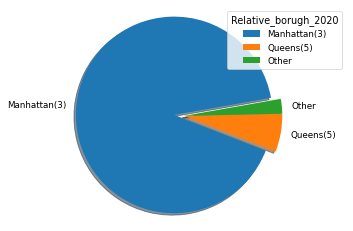

In [275]:
#Vẽ biểu đồ tròn thể tỉ lệ trên
raw_borugh = ['Manhattan(3)','Queens(5)','Other']
borugh_share = [91.33,6.24,2.43]
Explode = [0.1,0,0]
plt.pie(borugh_share, explode=Explode, labels=raw_borugh, shadow=True, startangle=10)
plt.axis('equal') 
plt.legend(title = 'Relative_borugh_2020')
plt.show()

- Theo biểu đồ như trên, chúng ta có thể phân vùng dữ liệu ở quận Manhanttan để tiến hình đi phân tích dữ liệu và giải quyết bài toán

##Thăm dò dữ liệu chuyến đi ở Manhattan

In [17]:
#Truy vấn dữ liệu của quận Manhattan với nhãn được gán là 3 trước đó
data_2020_manhattan = new_data.query("borugh_label == 3.0")

# Số lượng các chuyến xe của các khu vực trong quận
data_manhattan_polc_2020 = data_2020_manhattan.PULocationID.groupby(data_2020_manhattan.PULocationID).count()
data_manhattan_polc_2020 = data_manhattan_polc_2020.compute().sort_values(ascending=False)
# Tỉ lệ % số các chuyến xe giữa các khu vực trong quận 
relative_mahattan_2020 = (data_manhattan_polc_2020 * 100 / data_manhattan_polc_2020.sum()) + 1e-10


In [34]:
data_manhattan_polc_2020

PULocationID
237.0    740022
236.0    702418
161.0    699262
162.0    599655
186.0    588553
          ...  
202.0       875
153.0       396
128.0       194
120.0       125
105.0         7
Name: PULocationID, Length: 67, dtype: int64

In [23]:
len(data_manhattan_polc_2020)

67

In [277]:
relative_mahattan_2020.head

<bound method NDFrame.head of PULocationID
237.0    4.809545
236.0    4.565149
161.0    4.544638
162.0    3.897273
186.0    3.825119
           ...   
202.0    0.005687
153.0    0.002574
128.0    0.001261
120.0    0.000812
105.0    0.000045
Name: PULocationID, Length: 67, dtype: float64>

In [18]:
!pip install squarify

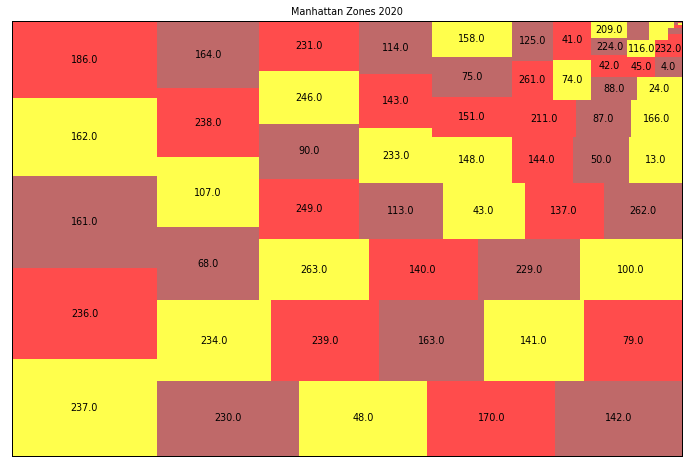

In [20]:
# tree map
import squarify
#fig = figsize=(16,10)
#ax = fig.add_subplot()

fig, ax = plt.subplots(1, figsize=(12,8))
ax.set_title("Manhattan Zones 2020")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
count_indices = list(relative_mahattan_2020.index)
indices = ["" if i > 55 else count_indices[i] for i in range(len(count_indices))]
squarify.plot(sizes=relative_mahattan_2020.values, label=indices, alpha=.7, color = ["yellow","red","brown"],ax=ax)
plt.show()

**Thêm một cột mới chứa các nhãn của các quận trong thành phố được picked từ Manhattan đến các khu vực này**

In [36]:
zone_dict = dict(zip(zone_lookup.LocationID, zone_lookup.Label))
# Sử dụng bộ từ điển có sẵn trong data zone_lookup chuẩn hóa các khu vực được trả khách dạng text thành nhãn số
data_2020_manhattan["DBorugh"] = data_2020_manhattan.DOLocationID.map(zone_dict)
data_2020_manhattan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,borugh_label,DBorugh
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238.0,239.0,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,3,3
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239.0,238.0,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,3,3
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238.0,238.0,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,3,3
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238.0,151.0,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,3,3
9,1.0,2020-01-01 00:29:01,2020-01-01 00:40:28,2.0,0.7,1.0,N,246.0,48.0,1.0,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,3,3


In [21]:
len(data_2020_manhattan)

15386529

In [37]:
#Đếm số lượng các chuyến xe được dropoff từ Manhattan
data_2020_manhattan_dlc = data_2020_manhattan.DBorugh.value_counts().compute()
# Tỉ lệ % số các chuyến xe được dropoff từ Manhattan
relative_data_2020_manhattan_dlc = data_2020_manhattan_dlc * 100/data_2020_manhattan_dlc.sum()

In [38]:
data_2020_manhattan_dlc

3    14310435
4      469412
1      430714
0      109702
6       36747
2       26579
5        2940
Name: DBorugh, dtype: int64

In [39]:
relative_data_2020_manhattan_dlc

3    93.006259
4     3.050799
1     2.799293
0     0.712974
6     0.238826
2     0.172742
5     0.019108
Name: DBorugh, dtype: float64

- Vì dữ liệu cung cấp để giải quyết bài toán trên đều nằm ở quận Manhattan nên bộ dữ liệu cuối cùng chúng ta lấy là data_2020_manhattan

##Thăm dò các features có thể liên quan đến bài toán đặt ra của bộ dữ liệu quận Manhatttan 

**Passenger_count**
 
Khách hành tối đa mà xe taxi yellow cho phép tùy loại xe có thể là 4 hoặc 5, đối với loại xe được 5 khách hàng có thể là 6 là do tính them trẻ nhỏ dưới 6 tuổi.


In [40]:
data_2020_manhattan.passenger_count.describe().compute()

count    1.525721e+07
mean     1.493621e+00
std      1.138906e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [41]:
print(len(data_2020_manhattan.query("passenger_count > 6")))

81


In [42]:
print(len(data_2020_manhattan.query("passenger_count == 0")))

304802


**RatecodeID, payment_type**

In [43]:
#Show số lượng các loại mã tỷ giá sau khi hoàn thành chuyến đi
data_2020_manhattan.RatecodeID.value_counts().compute()

1.0     15054769
2.0       123938
5.0        46023
3.0        29025
4.0         2896
99.0         505
6.0           55
Name: RatecodeID, dtype: int64

In [44]:
#Show số lượng hình thức thanh toán của khách hàng
data_2020_manhattan.payment_type.value_counts().compute()

1.0    11420993
2.0     3719915
3.0       73232
4.0       43061
5.0          10
Name: payment_type, dtype: int64

**Trip_distance, fare_amount**

In [45]:
trip_2020 = data_2020_manhattan.trip_distance.describe().compute()
trip_2020

count    1.538653e+07
mean     2.379665e+00
std      6.963324e+01
min     -2.947000e+01
25%      1.000000e+00
50%      1.720000e+00
75%      3.190000e+00
max      2.203862e+05
Name: trip_distance, dtype: float64

In [46]:
mean_2020 = trip_2020["mean"]
std_2020 = trip_2020["std"]
# the lowest zscore is -1 so there are no outliers on the lower side
ub_2020 = (3.0 * std_2020) + mean_2020
ub_2020

211.27939429815473

In [47]:
fare_2020 = data_2020_manhattan.fare_amount.describe().compute()
fare_2020

count    1.538653e+07
mean     1.102835e+01
std      2.033150e+02
min     -1.238000e+03
25%      6.500000e+00
50%      9.000000e+00
75%      1.400000e+01
max      6.711001e+05
Name: fare_amount, dtype: float64

In [48]:
mean_2020 = fare_2020["mean"]
std_2020 = fare_2020["std"]
# the lowest zscore is -1 so there are no outliers on the lower side
ub_2020 = (3.0 * std_2020) + mean_2020
ub_2020

620.9731998193503

#DATA CLEANSING, FEATURES ENGINEERING

Ở mục này chúng ta đi làm sạch và lọc dữ liệu những features có liên quan đến bài toán của chúng ta như : passenger_count, trip_distance, fare_amount và cột thời gian trả khách tpep_dropoff_datetime và features mới là DBorugh



In [49]:
# Filter trips that end in Manhattan
data_2020_manhattan_drop= data_2020_manhattan.query("DBorugh == 3")

## Remove những dữ liệu trong features Passenger_count 

In [50]:
data_2020_manhattan_drop = data_2020_manhattan_drop.query("0 < passenger_count <= 6")

##Chuẩn hóa features RatecodeID, payment_type, trip_distance, fare_amount 

In [51]:
# Lấy mã tỉ giá chủ yếu
data_2020_manhattan_drop = data_2020_manhattan_drop.query("RatecodeID == 1")

In [52]:
# Lấy 2 hình thức thanh toán chiếm đa số
data_2020_manhattan_drop = data_2020_manhattan_drop.query("1 <= payment_type <= 2")

In [53]:
# Loại bỏ những dữ liệu khoảng cách mang giá trị âm 
data_2020_manhattan_drop = data_2020_manhattan_drop.query("trip_distance >= 0")
#Chuyển khoảng cách từ dặm sang km 
data_2020_manhattan_drop["trip_distance_VN"] = (data_2020_manhattan_drop["trip_distance"]/0.621371192)

In [54]:
#Gia trị nhỏ nhất cho một chuyến xe taxi yellow hiện tại mới nhất là 2.50$, lấy fare lớn hơn khoảng này
data_2020_manhattan_drop = data_2020_manhattan_drop.query("fare_amount >= 2.50")

## Chuẩn hóa cột dữ liệu thời gian để tính thời lượng của một chuyến xe

In [55]:
# Chuyển cột thời gian nhận cuốc xe taxi thành hàng ngang dễ phân tích và so sánh với các cột còn lại
data_2020_manhattan_durat = data_2020_manhattan_drop.set_index("tpep_pickup_datetime")

In [56]:
data_2020_manhattan_durat.head(8)

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,borugh_label,DBorugh,trip_distance_VN
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.0,2020-01-01 00:13:03,1.0,2.20,1.0,N,68.0,170.0,1.0,10.5,3.0,0.5,2.85,0.0,0.3,17.15,2.5,3,3,3.540557
2020-01-01 00:00:00,2.0,2020-01-01 01:08:55,5.0,1.43,1.0,N,48.0,239.0,2.0,6.5,0.5,0.5,0.00,0.0,0.3,10.30,2.5,3,3,2.301362
2020-01-01 00:00:00,2.0,2020-01-01 01:45:06,5.0,1.35,1.0,N,48.0,68.0,2.0,8.5,0.5,0.5,0.00,0.0,0.3,12.30,2.5,3,3,2.172614
2020-01-01 00:00:00,2.0,2020-01-01 02:02:39,5.0,2.33,1.0,N,186.0,79.0,2.0,11.5,0.5,0.5,0.00,0.0,0.3,15.30,2.5,3,3,3.749772
2020-01-01 00:00:00,2.0,2020-01-01 04:17:14,5.0,0.96,1.0,N,68.0,50.0,2.0,5.5,0.5,0.5,0.00,0.0,0.3,9.30,2.5,3,3,1.544970
2020-01-01 00:00:02,2.0,2020-01-01 00:16:49,1.0,1.68,1.0,N,68.0,246.0,2.0,11.0,0.5,0.5,0.00,0.0,0.3,14.80,2.5,3,3,2.703698
2020-01-01 00:00:03,1.0,2020-01-01 00:13:04,2.0,3.00,1.0,N,79.0,162.0,1.0,11.5,3.0,0.5,2.00,0.0,0.3,17.30,2.5,3,3,4.828032
2020-01-01 00:00:07,1.0,2020-01-01 00:03:26,3.0,0.60,1.0,N,75.0,75.0,2.0,4.5,0.5,0.5,0.00,0.0,0.3,5.80,0.0,3,3,0.965606


In [57]:
data_2020_manhattan_durat["Duration"] = (data_2020_manhattan_durat.tpep_dropoff_datetime - data_2020_manhattan_durat.index).astype('timedelta64[s]')
# Sau khi tính được như trên thời gian sẽ là giây và chúng ta convert sang giờ
data_2020_manhattan_durat["Duration"] = (data_2020_manhattan_durat["Duration"]/3600.)
# Thêm features vận tốc
data_2020_manhattan_durat["Speed"] = data_2020_manhattan_durat.trip_distance_VN / data_2020_manhattan_durat.Duration

In [58]:
# Loại bỏ dữ liệu thời lượng chuyến đi mang giá trị âm
data_2020_manhattan_durat = data_2020_manhattan_durat.query("Duration > 0")

In [59]:
len(data_2020_manhattan_durat)

13806846

##FEATURES ENGINEERING

In [60]:
scolumns = ['PULocationID','passenger_count', 'trip_distance_VN','Duration','fare_amount']
data_2020_manhattan_final = data_2020_manhattan_durat[scolumns]

In [22]:
#Chọn các  locations có chiếm tỉ lệ cao trong bộ data của quận manhattan
locations = [211.0, 143.0,  87.0, 125.0, 166.0,  41.0, 151.0,  74.0, 233.0,
              144.0, 158.0, 236.0,  75.0, 140.0, 137.0, 237.0,  50.0, 113.0,
              246.0, 238.0, 231.0, 239.0, 114.0, 142.0, 161.0, 229.0, 163.0,
              148.0, 162.0, 170.0, 263.0, 234.0, 141.0, 186.0,  90.0, 100.0,
              107.0, 164.0, 249.0,  68.0,  48.0,  79.0, 230.0]

In [62]:
data_2020_manhattan_final.head()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount
tpep_pickup_datetime,,,,,
2020-01-01,68.0,1.0,3.540557,0.217500,10.5
2020-01-01,48.0,5.0,2.301362,1.148611,6.5
2020-01-01,48.0,5.0,2.172614,1.751667,8.5
2020-01-01,186.0,5.0,3.749772,2.044167,11.5
2020-01-01,68.0,5.0,1.544970,4.287222,5.5


In [63]:
data_2020_manhattan_final.isnull().sum().compute()

PULocationID        0
passenger_count     0
trip_distance_VN    0
Duration            0
fare_amount         0
dtype: int64

In [64]:
data_2020_manhattan_final.describe().compute()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount
count,1.380685e+07,1.380685e+07,1.380685e+07,1.380685e+07,1.380685e+07
mean,1.666818e+02,1.526108e+00,2.990907e+00,2.248800e-01,9.465929e+00
std,6.629008e+01,1.133209e+00,2.332482e+00,9.941903e-01,4.965379e+00
min,4.000000e+00,1.000000e+00,0.000000e+00,2.777778e-04,2.500000e+00
25%,1.400000e+02,1.000000e+00,1.544970e+00,1.111111e-01,6.500000e+00
50%,1.630000e+02,1.000000e+00,2.558857e+00,1.730556e-01,8.500000e+00
75%,2.360000e+02,2.000000e+00,4.152108e+00,2.672222e-01,1.200000e+01
max,2.630000e+02,6.000000e+00,4.910109e+02,1.420853e+02,4.265000e+03


- Độ lệch chuẩn của thời lượng là khoảng gần 1 giờ

- Nhưng vì chúng ta chỉ chọn 1 khu vực để train model nên chọn độ lệch thời gian cho các sample tiếp theo là 10min

- Bộ dữ liệu cuối cùng sẽ được gộp lại các feature vẫn giữ nguyên sẽ được tính tổng lại trong thời điểm nhất định

In [65]:
#Đưa cảnh báo cho modules resample(time)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    resample_duration = ["10min","1H"]
    for dur in resample_duration:
        data_2020_manhattan_final_resampled = data_2020_manhattan_final.groupby("PULocationID").apply(lambda x: x.resample(dur).sum()).compute()
        data_2020_manhattan_final_resampled = data_2020_manhattan_final_resampled.drop("PULocationID", axis=1)
        # Xuất ra vận tốc trung bình trong khoảng gian 
        data_2020_manhattan_final_resampled["Speed"] = data_2020_manhattan_final_resampled.trip_distance_VN / data_2020_manhattan_final_resampled.Duration
        #Lưu lại file     
        data_2020_manhattan_final_resampled.to_csv(f"/content/data_2020_manhattan_final_resampled_{dur}.csv")

In [66]:
data_2020_manhattan_final_resampled.head()

passenger_count  ...      Speed
PULocationID tpep_pickup_datetime                   ...           
100.0        2020-01-01 00:00:00              42.0  ...  11.300630
             2020-01-01 01:00:00             113.0  ...  12.330194
             2020-01-01 02:00:00             187.0  ...  17.375645
             2020-01-01 03:00:00             167.0  ...   9.154402
             2020-01-01 04:00:00              77.0  ...  22.552264

[5 rows x 5 columns]

In [13]:
#Đọc dữ liệu của quận manhattan với độ lệch thời gian của các sample là 10min
data_2020_manhattan_final_10min = pd.read_csv(f"/content/data_2020_manhattan_final_resampled_10min.csv", index_col=1)
data_2020_manhattan_final_10min.index = pd.to_datetime(data_2020_manhattan_final_10min.index)
data_2020_manhattan_final_10min.tail()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount,Speed
tpep_pickup_datetime,,,,,,
2020-06-30 20:00:00,261.0,0.0,0.000000,0.000000,0.0,NaN
2020-06-30 20:10:00,261.0,0.0,0.000000,0.000000,0.0,NaN
2020-06-30 20:20:00,261.0,0.0,0.000000,0.000000,0.0,NaN
2020-06-30 20:30:00,261.0,3.0,3.250875,0.182500,9.5,17.813013
2020-06-30 20:40:00,261.0,1.0,4.425696,0.100833,9.0,43.891200


- Ví dụ như trên cột tpep_pickup_datetime là khoảng thời điểm thì ta có các giá trị nhất định của các features  

###Final EDA

In [14]:
print(data_2020_manhattan_final_10min.index)
print(data_2020_manhattan_final_10min.fare_amount.describe())

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:10:00',
               '2020-01-01 00:20:00', '2020-01-01 00:30:00',
               '2020-01-01 00:40:00', '2020-01-01 00:50:00',
               '2020-01-01 01:00:00', '2020-01-01 01:10:00',
               '2020-01-01 01:20:00', '2020-01-01 01:30:00',
               ...
               '2020-06-30 19:10:00', '2020-06-30 19:20:00',
               '2020-06-30 19:30:00', '2020-06-30 19:40:00',
               '2020-06-30 19:50:00', '2020-06-30 20:00:00',
               '2020-06-30 20:10:00', '2020-06-30 20:20:00',
               '2020-06-30 20:30:00', '2020-06-30 20:40:00'],
              dtype='datetime64[ns]', name='tpep_pickup_datetime', length=1858404, freq=None)
count    1.858404e+06
mean     7.032627e+01
std      1.642848e+02
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      4.450000e+01
max      4.719500e+03
Name: fare_amount, dtype: float64


In [15]:
# Xuất thử kết quả một khu vực 
data_2020_manhattan_final_10min.query("PULocationID == 237").head()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount,Speed
tpep_pickup_datetime,,,,,,
2020-01-01 00:00:00,237.0,44.0,108.904309,5.208611,294.0,20.908512
2020-01-01 00:10:00,237.0,118.0,199.639123,11.191389,621.0,17.838637
2020-01-01 00:20:00,237.0,180.0,263.546174,38.904722,862.5,6.774144
2020-01-01 00:30:00,237.0,156.0,305.163809,16.082222,912.0,18.975227
2020-01-01 00:40:00,237.0,161.0,253.584334,18.091389,890.0,14.016853


In [16]:
data_2020_manhattan_final_10min.shape

(1858404, 6)

In [17]:
#Xuất ra các giá trị khuyết của features Speed
print(len(data_2020_manhattan_final_10min[data_2020_manhattan_final_10min.Speed.isnull()]))

896114


In [18]:
# Điều các giá trị khuyết
data_2020_manhattan_final_10mins = data_2020_manhattan_final_10min.replace(to_replace=0, method="ffill")
# Tính toán lại cột Speed
data_2020_manhattan_final_10mins.Speed.fillna(data_2020_manhattan_final_10mins.trip_distance_VN/data_2020_manhattan_final_10mins.Duration, inplace=True)

In [19]:
data_2020_manhattan_final_10mins.head()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount,Speed
tpep_pickup_datetime,,,,,,
2020-01-01 00:00:00,100.0,2.0,11.909146,0.617778,31.0,19.277394
2020-01-01 00:10:00,100.0,2.0,6.582217,0.791944,31.0,8.311463
2020-01-01 00:20:00,100.0,3.0,3.701491,0.400000,17.5,9.253728
2020-01-01 00:30:00,100.0,15.0,12.488509,1.645556,64.5,7.589236
2020-01-01 00:40:00,100.0,6.0,7.209861,0.858889,36.5,8.394405


In [20]:
data_2020_manhattan_final_10mins.shape

(1858404, 6)

In [23]:
#Chọn dữ liệu khu vực cần train cho bài toán
selected_data_2020_manhattan = {loc:data_2020_manhattan_final_10mins.query(f"PULocationID == {loc}") for loc in locations}

- Ở đây chúng ta chọn dữ liệu khu vực 237 để đi train và đánh giá model là vì số lượng các chuyến xe taxi được thực hiện nhiều nhất, cũng như tỉ lệ % của nó cũng chiếm tỉ lệ cao nhất trong tất cả khu vực. Chúng ta làm như thế này vừa có thể không thay đổi dự liệu để giải quyết bài toán, vừa có thể rút gọn được dữ liệu về kích thước nhỏ hơn tiết kiệm được rất nhiều thời gian để train model.

## Chọn khu vực để tiến hành thực hiện bài toán dự đoán

In [29]:
selected_data_2020_manhattan_237 = selected_data_2020_manhattan[237]
selected_data_2020_manhattan_237.head()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount,Speed
tpep_pickup_datetime,,,,,,
2020-01-01 00:00:00,237.0,44.0,108.904309,5.208611,294.0,20.908512
2020-01-01 00:10:00,237.0,118.0,199.639123,11.191389,621.0,17.838637
2020-01-01 00:20:00,237.0,180.0,263.546174,38.904722,862.5,6.774144
2020-01-01 00:30:00,237.0,156.0,305.163809,16.082222,912.0,18.975227
2020-01-01 00:40:00,237.0,161.0,253.584334,18.091389,890.0,14.016853


In [76]:
check_237_1 = selected_data_2020_manhattan_237["2020-03":"2020-04"]
check_237_1.tail()

,PULocationID,passenger_count,trip_distance_VN,Duration,fare_amount,Speed
tpep_pickup_datetime,,,,,,
2020-04-30 23:10:00,237.0,1.0,3.701491,0.197778,10.5,18.715405
2020-04-30 23:20:00,237.0,1.0,3.701491,0.197778,10.5,18.715405
2020-04-30 23:30:00,237.0,1.0,4.184294,0.188889,11.0,22.152147
2020-04-30 23:40:00,237.0,1.0,4.345229,0.120000,9.5,36.210240
2020-04-30 23:50:00,237.0,1.0,4.345229,0.120000,9.5,36.210240


- Loại bỏ dữ liệu 3 tháng trên vì lúc trước đã không có dữ liệu nhưng vì điền giá trị khuyết vào nữa nên xử lí trùng lặp dữ liệu

#MODEL SELECTIONS

In [52]:
#Import libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
#from keras.models import Sequential

from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import  Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.utils import Sequence
# faster one
#from keras.layers import CuDNNLSTM
# to create custom metrics like RMSE
from keras import backend
# enable plotly for google_colab

# Import the libraries to model LSTM
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools

#Lấy hàm visulzie của LSTM TỪ webb
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script><script>requirejs.config({paths: {base: '/static/base',plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',},});</script>'''))

Using TensorFlow backend.


In [34]:
data_loc237 = selected_data_2020_manhattan_237.drop("PULocationID", axis=1)
train_237 = data_loc237["2020-01":"2020-02"].iloc[:, [0,1,2,4,3]]
test_237 = data_loc237["2020-03"].iloc[:, [0,1,2,4,3]]

In [31]:
data_loc237.shape

(37877, 5)

In [36]:
print(test_237.shape)
test_237.tail()

(4464, 5)


,passenger_count,trip_distance_VN,Duration,Speed,fare_amount
tpep_pickup_datetime,,,,,
2020-03-31 23:10:00,1.0,5.954573,0.189167,31.477918,12.5
2020-03-31 23:20:00,2.0,17.059046,0.454167,37.561203,34.0
2020-03-31 23:30:00,2.0,17.059046,0.454167,37.561203,34.0
2020-03-31 23:40:00,2.0,17.059046,0.454167,37.561203,34.0
2020-03-31 23:50:00,2.0,17.059046,0.454167,37.561203,34.0


##Multiple regression 

In [37]:
from sklearn.linear_model import LinearRegression
z = data_loc237[['passenger_count','trip_distance_VN','Duration','Speed']]
lm5 = LinearRegression()
lm5.fit(z,data_loc237['fare_amount'])
yhat5 = lm5.predict(z)

In [38]:
# phương pháp gọi hàm 
def rmse_score(yhat5,y):
  A= yhat5 -y
  B = np.square(A)
  Mse_score = np.mean(B)
  rmse_score = sqrt(Mse_score)
  return rmse_score
def Mse_core(yhat5,y):
  A= yhat5 -y
  B = np.square(A)
  Mse_score = np.mean(B)
  return Mse_score
def R2_core(yhat5,y):
  Y_tb = np.mean(y)
  C = Mse_core(Y_tb,y)
  D= Mse_core(yhat5,y)
  E = 1-D/C
  return E

In [39]:
y= data_loc237['fare_amount']
rmse_h6 = rmse_score(yhat5,y)
print('Rmse theo pp gọi hàm :', rmse_h6)
R2_6 = R2_core(yhat5,y)
print('R2 theo pp gọi hàm :', R2_6)

Rmse theo pp gọi hàm : 31.425976692164554
R2 theo pp gọi hàm : 0.9896536733932236


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



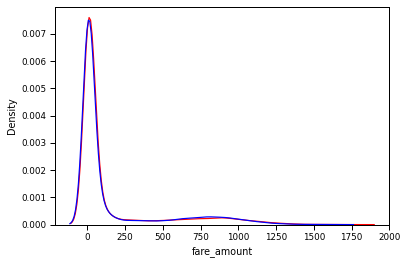

In [40]:
# Phát họa Distribution plot để đánh giá mô hình
ax1 = sns.distplot(y, hist= False, color= 'r', label= 'Actual Value')
sns.distplot(yhat5, hist= False, color= 'b', label= 'Fitted Value', ax= ax1)
plt.show()

## Polynomial Regression


In [41]:
from sklearn.preprocessing import PolynomialFeatures
Z =data_loc237[['passenger_count']]
pr=PolynomialFeatures(degree=3, include_bias=False)
X_poly = pr.fit_transform(Z)
X_poly.shape
lm7= LinearRegression()
lm7.fit(X_poly,data_loc237['fare_amount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
data_loc237['fare_amount']
lm8 =  LinearRegression()
lm8.fit(X_poly,y)
yhat8 = lm8.predict(X_poly)
# phương pháp gọi hàm 
def Mse_core(yhat8,y):
  A= yhat8 -y
  B = np.square(A)
  Mse_score = np.mean(B)
  return Mse_score
def rmse_score(yhat8,y):
  A= yhat8 -y
  B = np.square(A)
  Mse_score = np.mean(B)
  rmse_score = sqrt(Mse_score)
  return rmse_score
def R2_core(yhat8,y):
  Y_tb = np.mean(y)
  C = Mse_core(Y_tb,y)
  D= Mse_core(yhat8,y)
  E = 1-D/C
  return E
rmse_h8 = rmse_score(yhat8,y)
print('Mse theo pp gọi hàm :', rmse_h8)
r2_core_8 = R2_core(yhat8,y)
print('R2 theo pp gọi hàm :', r2_core_8)

Mse theo pp gọi hàm : 41.744327568158496
R2 theo pp gọi hàm : 0.9817440870981398


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



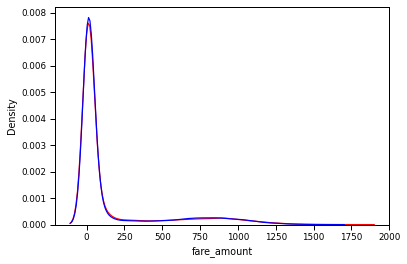

In [43]:
# Phát họa Distribution plot để đánh giá mô hình
ax8 = sns.distplot(y, hist= False, color= 'r', label= 'Actual Value')
sns.distplot(yhat8, hist= False, color= 'b', label= 'Fitted Value', ax= ax8)
plt.show()

In [44]:
# earliest to latest
list(range(15, 0, -1))

[15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

##LSTM - MODEL DEEP LEARNIG

In [45]:
# a method to create lagged features and convert them to 3D format.
def convert_to_sequence(train, test, time_steps, normalized):
  scaler = None
  # normalize data
  if (normalized==True):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_df = pd.DataFrame(scaler.fit_transform(train.values.reshape(-1,1)), columns=["fare_amount"])
    test_df = pd.DataFrame(scaler.transform(test.values.reshape(-1,1)), columns=["fare_amount"])
  else:
    train_df = pd.DataFrame(train, columns=["fare_amount"])
    test_df = pd.DataFrame(test, columns=["fare_amount"])
    
  lags = range(time_steps, 0, -1)
  train_df = train_df.assign(**{str(t): train_df.fare_amount.shift(t) for t in lags})
  train_df.dropna(inplace=True)
  test_df = test_df.assign(**{str(t): test_df.fare_amount.shift(t) for t in lags})
  test_df.dropna(inplace=True)

  # lagged features start from column1
  X_train = train_df.iloc[:, 1:].values.reshape(len(train_df), time_steps, 1)
  # fare_amount 
  y_train = train_df.iloc[:, 0].values.reshape(len(train_df), 1)
  X_test = test_df.iloc[:, 1:].values.reshape(len(test_df), time_steps, 1)
  y_test = test_df.iloc[:, 0].values.reshape(len(test_df), 1)
  return X_train, X_test, y_train, y_test, scaler

In [46]:
# root mean squared error (rmse) for regression cho Keras
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  cho Keras
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true), axis=-1)
# R2-score metrics cho Kkeras 
def r2_score(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + backend.epsilon))

In [47]:
def vanilla_lstm(train, test, lags, memory_cells, epochs, normalized):
  X_train, X_test, y_train, y_test, scaler = convert_to_sequence(train, test, lags, normalized)
  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  model = Sequential()
  model.add(LSTM(memory_cells, input_shape=(lags, 1)))
  #model.add(Dropout(0.4))
  model.add(Dense(1, activation="linear" ))
  model.compile(loss="mse", optimizer="rmsprop", metrics=[rmse])
  #print(model.summary())
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),batch_size=200, verbose=0)
  return model, history, scaler, X_train, X_test, y_train, y_test

In [48]:
def plot_predictions(model, X_train, y_train, X_test, y_test, limit):
  configure_plotly_browser_state()
#   train_indices = y_train.index.iloc[:limit]
#   test_indices = y_test.index.iloc[:limit]

  y_pred_train = model.predict(X_train).flatten()[:limit]
  y_pred_test = model.predict(X_test).flatten()[:limit]
  y_true_train = y_train.flatten()[:limit]
  y_true_test = y_test.flatten()[:limit]
 
  # https://coolors.co
  colors = ['#04E762', '#F5B700', '#00A1E4', '#DC0073']
  
  trace1 = go.Scatter(y=list(y_pred_train), mode="lines", name="Prediction",
                      marker = dict(size = 15,
                                    color = colors[0]
                                    ))
  trace2 = go.Scatter(y=list(y_true_train), mode="markers", name="Actual",
                      marker = dict(size = 3,
                                    color = colors[1]
                                    ))
  
  trace3 = go.Scatter(y=list(y_pred_test), mode="lines", name="Prediction",
                      marker = dict(size = 15,
                                    color = colors[0]
                                    ),
                     showlegend=False)
  trace4 = go.Scatter(y=list(y_true_test), mode="markers", name="Actual",
                      marker = dict(size = 3,
                                    color = colors[1]
                                    ),
                     showlegend=False)

  train_trace= [trace1, trace2]
  test_trace = [trace3, trace4]

  
  fig = tools.make_subplots(rows=1, cols=2, shared_yaxes=True, shared_xaxes=True, subplot_titles=('Train', 'Test'))
#   fig.add_trace(trace1, 1,1)
#   fig.add_trace(trace2,1,2)
#   fig.add_trace(trace3,2,1)
#   fig.add_trace(trace4,2,2)

  fig.add_traces(train_trace, rows=[1, 1], cols=[1,1])
  fig.add_traces(test_trace, rows=[1,1], cols=[2,2])                                                         


  fig['layout']['xaxis1'].update(title='Time Step')
  fig['layout']['xaxis2'].update(title='Time Step')


  fig['layout']['yaxis1'].update(title='RMSE Predicting')
  # it is shared
  #fig['layout']['yaxis2'].update(title='R2')


  fig['layout'].update(height=400, width=600, title='Model performance of time step trained')
  config={'scrollZoom':False,'displayModeBar':True, "showLink":False, 'showTips':False}
  pyo.iplot(fig, filename='make-subplots-multiple-with-titles', config=config)

In [53]:
# 12 steps back
# 60 units
model_one, history_one, _, X_train, X_test, y_train, y_test = vanilla_lstm(train_237.fare_amount, test_237.fare_amount, 12, 60, 100, False)
# print train and validation accuracy
print("RMSE_train:{}, RMSE_test:{}".format(history_one.history["rmse"][-1], history_one.history['val_rmse'][-1]))

(8628, 12, 1) (8628, 1) (4452, 12, 1) (4452, 1)
RMSE_train:330.2954406738281, RMSE_test:138.57797241210938


#MODEL PERFORMANCE

In [54]:
plot_predictions(model_one, X_train, y_train, X_test, y_test, limit=100)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [264]:
model_three, history_three, scaler, X_train, X_test, y_train, y_test = vanilla_lstm(train_237.fare_amount, test_237.fare_amount,12, 60, 100, True)
# Tính độ đo Rmse của 2 tập train và test sau khi sacler về dạng 0 - 1
print("RMSE_train:{}, RMSE_test:{}".format(history_three.history["rmse"][-1], history_three.history['val_rmse'][-1]))

(8628, 12, 1) (8628, 1) (4452, 12, 1) (4452, 1)
RMSE_train:0.04043302312493324, RMSE_test:0.028790658339858055


In [265]:
# Chuyển về độ do thật
rmse_t =  scaler.inverse_transform(np.array(history_three.history["rmse"][-1]).reshape(-1,1)).flatten()
vrmse_t =  scaler.inverse_transform(np.array(history_three.history["val_rmse"][-1]).reshape(-1,1)).flatten()
print("RMSE_train_final:{}, RMSE_test_final:{}".format(rmse_t, vrmse_t))

RMSE_train_final:[71.70111908], RMSE_test_final:[51.77521175]


In [266]:
plot_predictions(model_three, X_train, y_train, X_test, y_test, limit=100)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# DEPLOY MODEL
- Tôi hiện tại vẫn chưa có nhiều ý tưởng việc này, nhưng trong tương lại có đủ thời gian, tôi nghĩ có thể làm tốt được phần này để cho giúp model của tôi sau khi train có thể phát triển hơn ở nhiều bài toán tương tự, cũng như ở nhiều bộ dữ liệu khác.

#CONCLUSION


- Tôi giải quyết và thực hiện thành công của bài toán mình đã đặt ra là đã dự đoán được nhu cầu đi Taxi màu vàng của khách hàng của từng khu vực trong thành phố đạt hiệu suất rất cao.

-  Ý tưởng ứng dụng bài toán này là: Chúng ta có thể cho bộ dữ liệu đầu vào của 2 hay nhiều hơn 2 khu vực, cho tất cả chúng training model, sau đó ta thu được kết quả hiệu suất dự đoán biến thiên của giá vé của mỗi khu vực với nhau trong cùng một khoảng thời gian cố định, cứ thể sau 10 phút/1 giờ người tài xế có thể đoán biết khu vực nào sẽ đông khách hay ít khách trong thời gian tiếp theo.
- Vẫn còn chưa đủ thời gian nghiên cứu làm bước deploy, tương lai tôi sẽ làm và mở rộng ứng dụng của bài toán.
